### Fama French 5 Factor Model

In [1]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

factors = pd.read_csv('5factor_daily.CSV', index_col = 0)
factors.index = pd.to_datetime(factors.index.astype(str))
factors = factors/100
factors = factors['2000-01-01':]

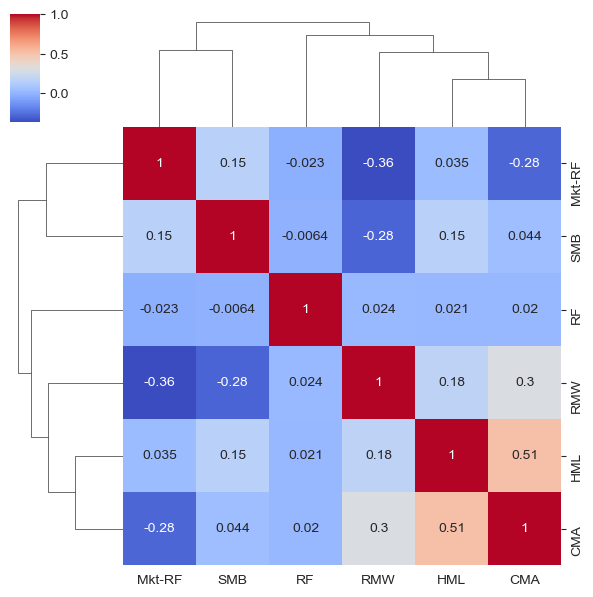

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

sns.clustermap(
    factors.corr(), 
    annot = True, 
    cmap = 'coolwarm', 
    figsize = (6, 6),
)

독립성 검정을 위해 공분산을 확인한다

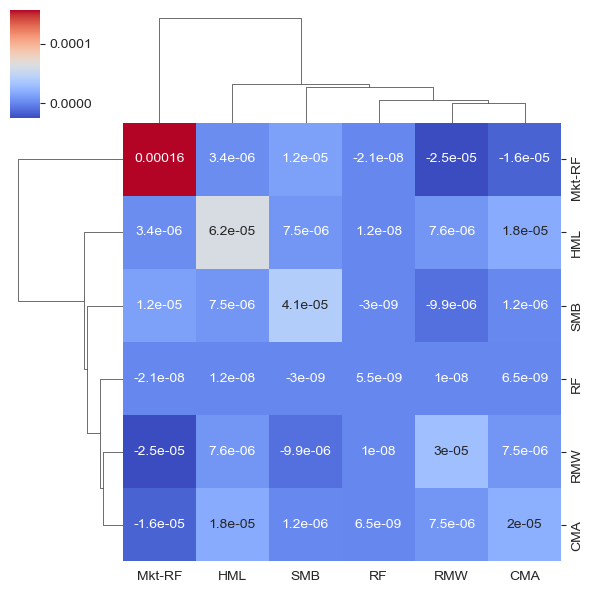

In [3]:
sns.clustermap(
    factors.cov(), 
    annot = True, 
    cmap = 'coolwarm', 
    figsize = (6, 6),
)

비선형적 관계까지 검정을 하기 위해서 mutual information을 확인한다

In [4]:
from sklearn.feature_selection import mutual_info_regression

def getMutualInfo(data):
    mi = np.zeros((data.shape[1], data.shape[1]))
    for i in range(data.shape[1]):
        for j in range(data.shape[1]):
            mi[i, j] = mutual_info_regression(
                data.iloc[:, i].values.reshape(-1, 1), 
                data.iloc[:, j].values.reshape(-1, 1), 
                random_state = 42
            )
    mi = pd.DataFrame(mi, index = data.columns, columns = data.columns)
    return mi

In [5]:
mi = getMutualInfo(factors)
mi

,Mkt-RF,SMB,HML,RMW,CMA,RF
Mkt-RF,5.954981,0.026986,0.052093,0.098288,0.054605,0.029131
SMB,0.033372,5.439414,0.020052,0.074640,0.016720,0.002094
HML,0.052848,0.022907,5.504892,0.077650,0.203383,0.049204
RMW,0.097893,0.072624,0.078981,5.267125,0.120552,0.044929
CMA,0.055084,0.018344,0.204056,0.123605,5.027978,0.044450
RF,0.030550,0.005712,0.048024,0.049387,0.042561,2.631934


Text(0.5, 1.0, 'Mutual Information')

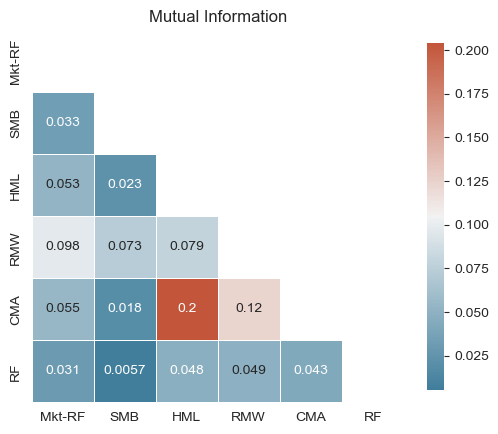

In [6]:
mask = np.triu(np.ones_like(mi, dtype = bool))
f, ax = plt.subplots(figsize = (6, 5))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
plt.grid(False)
sns.heatmap(mi, mask = mask, cmap = cmap,
            square = True, linewidths = .5, cbar_kws = {"shrink": .9}, annot = True)
plt.title('Mutual Information')

In [7]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X = factors[['RF', 'SMB', 'HML', 'RMW', 'CMA']]
X = sm.add_constant(X)
y = factors['Mkt-RF']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

In [8]:
ols = sm.OLS(y_train, X_train).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 Mkt-RF   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     317.8
Date:                Wed, 07 Feb 2024   Prob (F-statistic):          5.88e-295
Time:                        02:41:45   Log-Likelihood:                 15127.
No. Observations:                4829   AIC:                        -3.024e+04
Df Residuals:                    4823   BIC:                        -3.020e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.835      0.0

In [9]:
y_pred = ols.predict(X_test)
y_pred = pd.DataFrame(y_pred, index = y_test.index, columns = ['Mkt-RF'])
y_pred

,Mkt-RF
2019-03-15,0.001045
2019-03-18,0.003387
2019-03-19,-0.003035
2019-03-20,-0.000116
2019-03-21,-0.004131
...,...
2023-12-22,0.004808
2023-12-26,0.006365
2023-12-27,0.004411
2023-12-28,0.001648


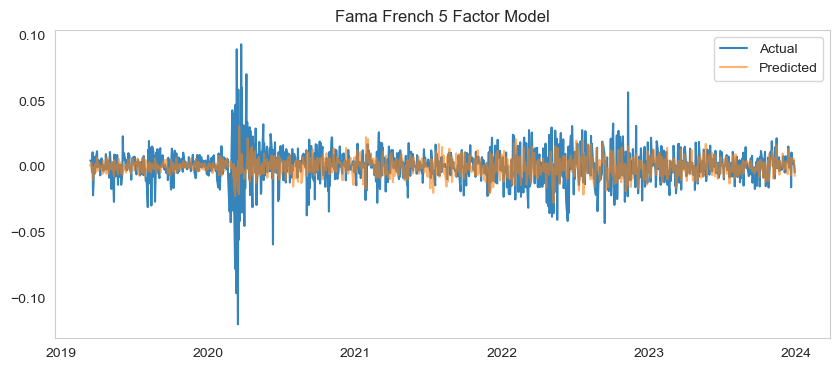

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 4))
plt.plot(y_test, label = 'Actual', alpha = 0.9)
plt.plot(y_pred, label = 'Predicted', alpha = 0.6)
plt.legend()
plt.title('Fama French 5 Factor Model')
plt.show()

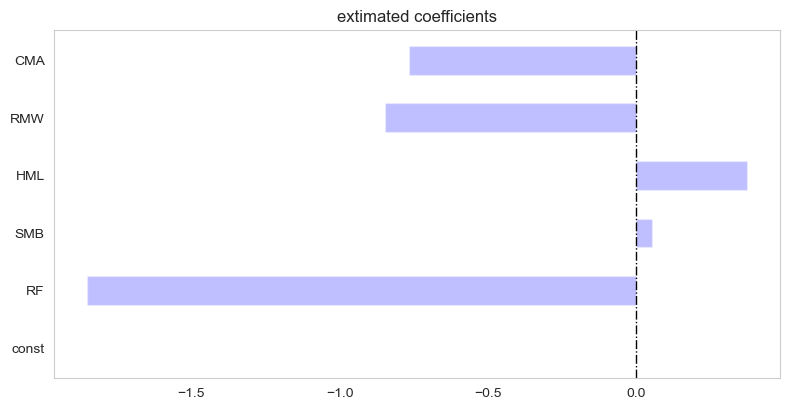

In [11]:
plt.figure(figsize = (8, 4))
plt.barh(
    ols.params.index, 
    ols.params, 
    color = 'b', 
    alpha = 0.25, 
    height = 0.5
)
plt.tight_layout()
plt.title('extimated coefficients')
plt.axvline(0, color = 'k', linestyle = '-.', linewidth = 1)
plt.show()

#### Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(
    n_estimators = 1000, 
    criterion = 'squared_error',
    random_state = 42
)
forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [13]:
y_pred = forest.predict(X_test)
y_pred = pd.DataFrame(y_pred, index = y_test.index, columns = ['Mkt-RF'])

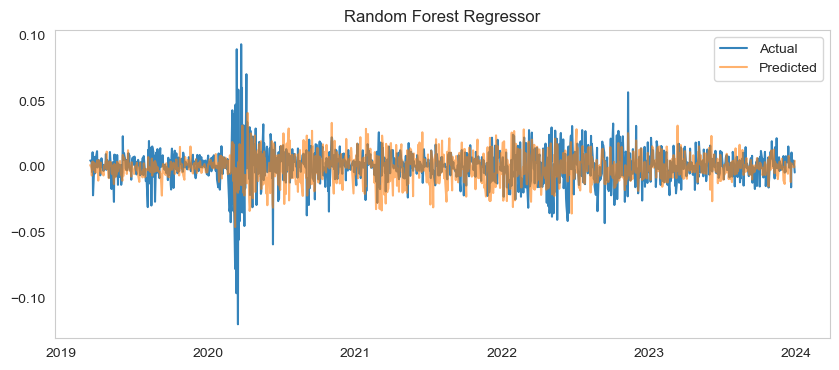

In [14]:
plt.figure(figsize = (10, 4))
plt.plot(y_test, label = 'Actual', alpha = 0.9)
plt.plot(y_pred, label = 'Predicted', alpha = 0.6)
plt.legend()
plt.title('Random Forest Regressor')
plt.show()

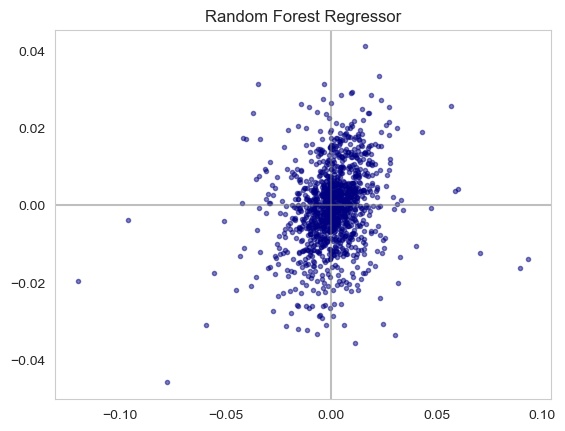

In [15]:
plt.axvline(0, color = 'grey', alpha = 0.5)
plt.axhline(0, color = 'grey', alpha = 0.5)
plt.scatter(y_test, y_pred, label = 'Returns', marker = '.', color = 'navy', alpha = 0.5)
plt.grid(False)
plt.title('Random Forest Regressor')
plt.show()

In [16]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, 
    X_test, 
    y_test, 
    n_repeats = 100, 
    random_state = 42
)

In [17]:
importance = pd.DataFrame(
    result.importances_mean, 
    index = X_test.columns, 
    columns = ['Importance']
)
importance = importance.sort_values(by = 'Importance', ascending = False)
importance

,Importance
CMA,0.194276
HML,0.139162
RMW,0.071446
SMB,0.008921
const,0.000000
RF,-0.017203


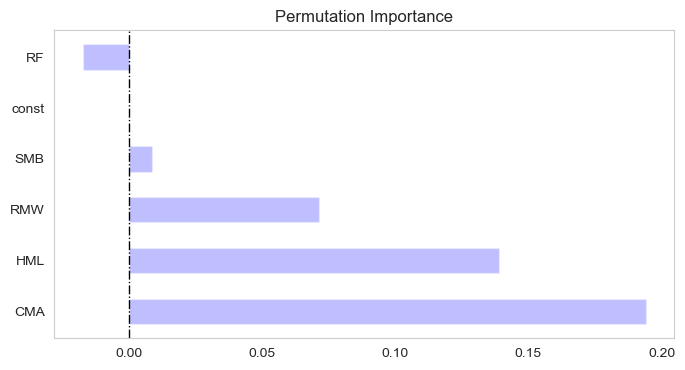

In [18]:
plt.figure(figsize = (8, 4))
plt.barh(
    importance.index, 
    importance['Importance'], 
    color = 'b', 
    alpha = 0.25, 
    height = 0.5
)
plt.axvline(0, color = 'k', linestyle = '-.', linewidth = 1)
plt.title('Permutation Importance')
plt.show()

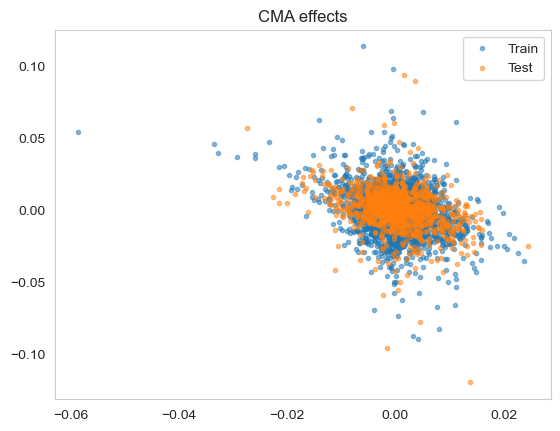

In [19]:
plt.scatter(X_train['CMA'], y_train, label = 'Train', marker = '.', alpha = 0.5)
plt.scatter(X_test['CMA'], y_test, label = 'Test', marker = '.', alpha = 0.5)
plt.legend()
plt.title('CMA effects')
plt.show()

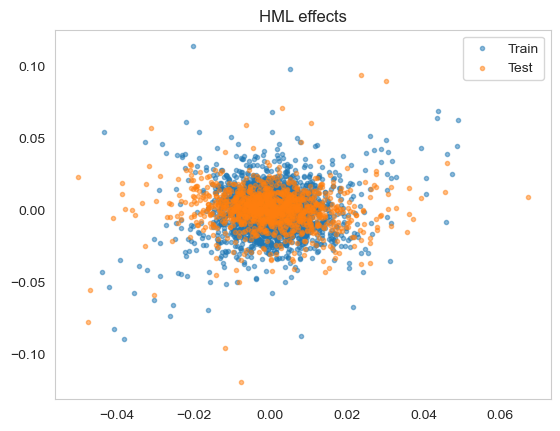

In [20]:
plt.scatter(X_train['HML'], y_train, label = 'Train', marker = '.', alpha = 0.5)
plt.scatter(X_test['HML'], y_test, label = 'Test', marker = '.', alpha = 0.5)
plt.legend()
plt.title('HML effects')
plt.show()

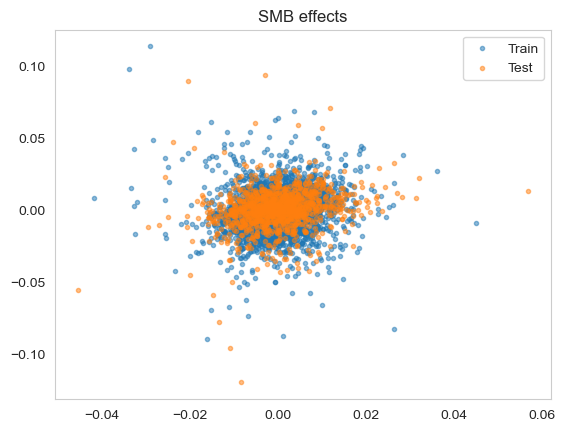

In [21]:
plt.scatter(X_train['SMB'], y_train, label = 'Train', marker = '.', alpha = 0.5)
plt.scatter(X_test['SMB'], y_test, label = 'Test', marker = '.', alpha = 0.5)
plt.legend()
plt.title('SMB effects')
plt.show()

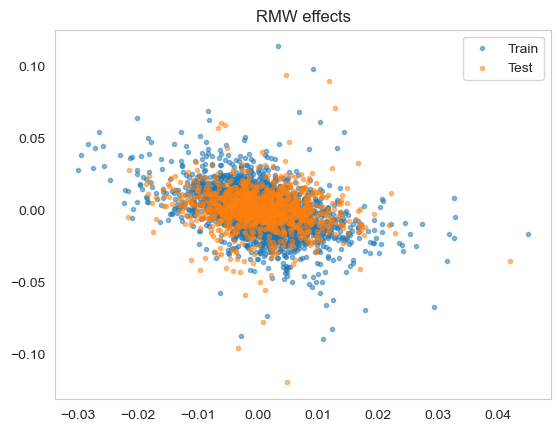

In [22]:
plt.scatter(X_train['RMW'], y_train, label = 'Train', marker = '.', alpha = 0.5)
plt.scatter(X_test['RMW'], y_test, label = 'Test', marker = '.', alpha = 0.5)
plt.legend()
plt.title('RMW effects')
plt.show()

#### Double Machine Learning

OLS와 비슷한 결과를 도출하는가?

**HML**

In [23]:
from econml.dml import LinearDML
from sklearn.linear_model import Ridge

dml_model = LinearDML(
    model_y = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    model_t = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    random_state = 42
)

In [24]:
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
    X[['const', 'SMB', 'RMW', 'CMA']], 
    X['HML'], 
    y, 
    test_size = 0.2, 
    shuffle = False
)

In [25]:
dml_model.fit(Y = y_train, 
              T = T_train, 
              X = X_train)

treatment_effect = dml_model.effect(X_train)

print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: 0.30593442966071566


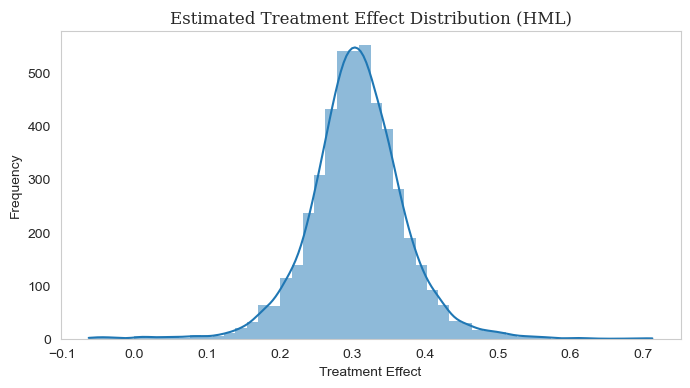

In [26]:
import seaborn as sns

plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution (HML)', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

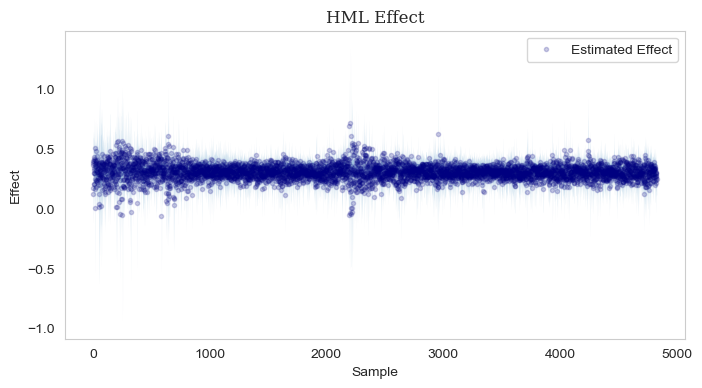

In [27]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_train)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_train)), treatment_effect_lower, treatment_effect_upper, alpha = 0.4)
plt.scatter(range(len(X_train)), treatment_effect, label='Estimated Effect', marker = '.', color = 'navy', alpha = 0.2)
plt.title('HML Effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

In [28]:
treatment_effect = dml_model.effect(X_test)
print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: 0.3045005105727368


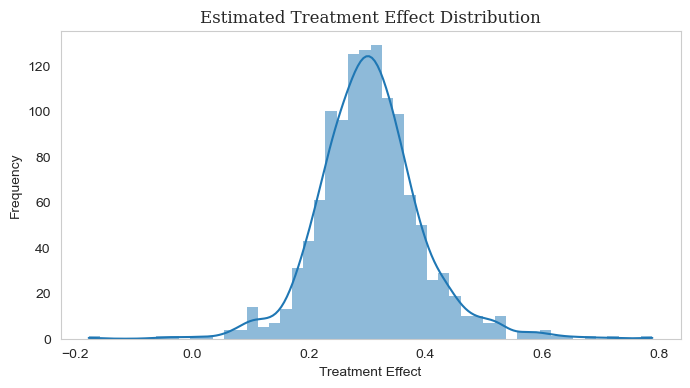

In [29]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

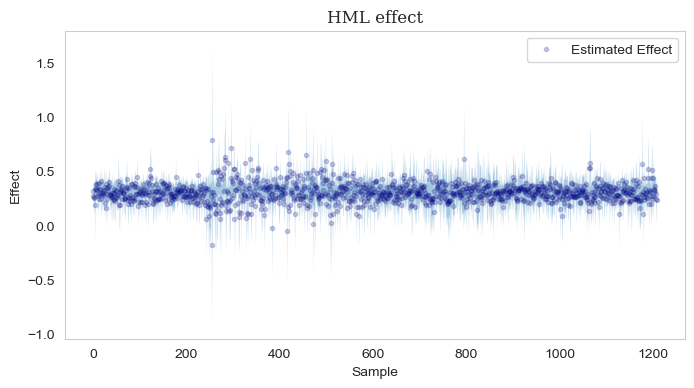

In [30]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_test)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_test)), treatment_effect_lower, treatment_effect_upper, alpha = 0.4)
plt.scatter(range(len(X_test)), treatment_effect, label='Estimated Effect', marker = '.', color = 'navy', alpha = 0.2)
plt.title('HML effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

**SMB**

In [31]:
dml_model = LinearDML(
    model_y = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    model_t = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    random_state = 42
)

X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
    X[['const', 'HML', 'RMW', 'CMA']], 
    X['SMB'], 
    y, 
    test_size = 0.2, 
    shuffle = False
)

In [32]:
dml_model.fit(Y = y_train, 
              T = T_train, 
              X = X_train)

treatment_effect = dml_model.effect(X_train)

print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: 0.042537928413007194


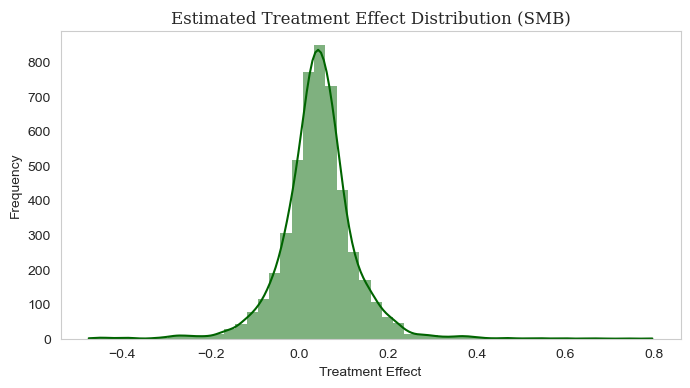

In [33]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None', color = 'darkgreen')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution (SMB)', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

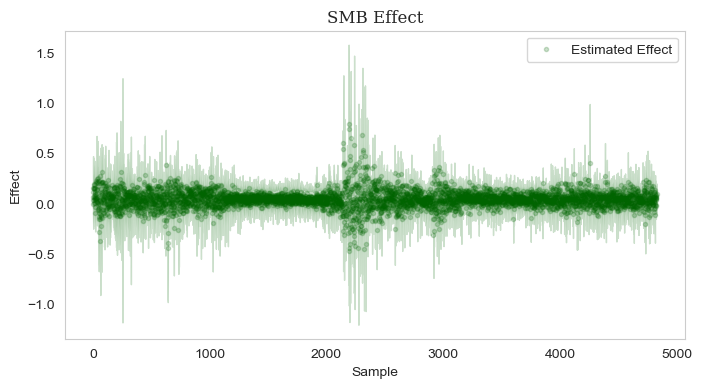

In [34]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_train)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_train)), treatment_effect_lower, treatment_effect_upper, alpha = 0.2, color = 'darkgreen')
plt.scatter(range(len(X_train)), treatment_effect, label = 'Estimated Effect', marker = '.', color = 'darkgreen', alpha = 0.2)
plt.title('SMB Effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

In [35]:
treatment_effect = dml_model.effect(X_test)
print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: 0.040469931819203234


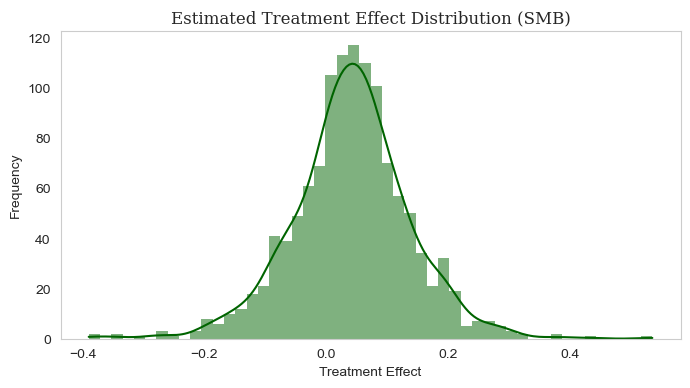

In [36]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None', color = 'darkgreen')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution (SMB)', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

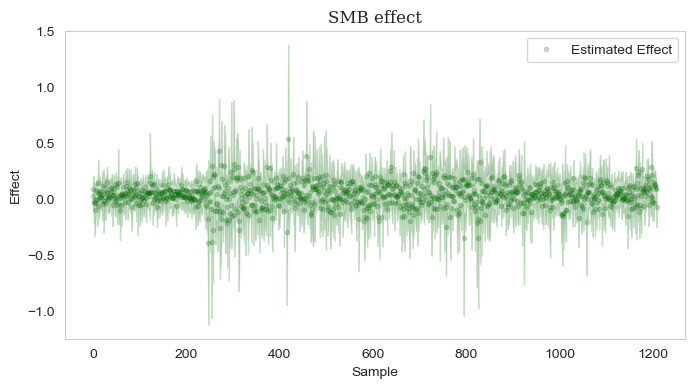

In [37]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_test)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_test)), treatment_effect_lower, treatment_effect_upper, alpha = 0.2, color = 'darkgreen')
plt.scatter(range(len(X_test)), treatment_effect, label='Estimated Effect', marker = '.', color = 'darkgreen', alpha = 0.2)
plt.title('SMB effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

**RMW**

In [38]:
dml_model = LinearDML(
    model_y = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    model_t = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    random_state = 42
)

X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
    X[['const', 'HML', 'SMB', 'CMA']], 
    X['RMW'], 
    y, 
    test_size = 0.2, 
    shuffle = False
)

In [39]:
dml_model.fit(Y = y_train, 
              T = T_train, 
              X = X_train)

treatment_effect = dml_model.effect(X_train)

print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: -0.7477296909779182


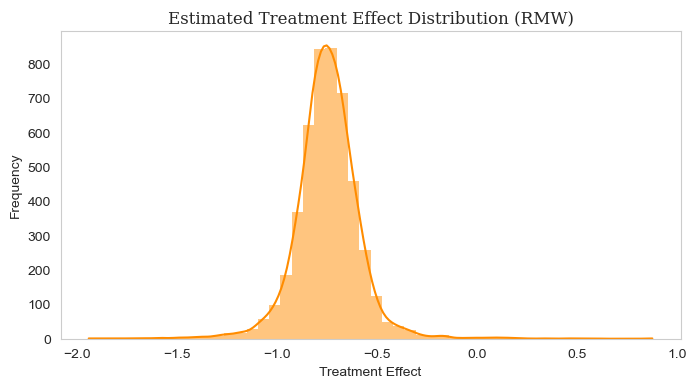

In [40]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None', color = 'darkorange')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution (RMW)', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

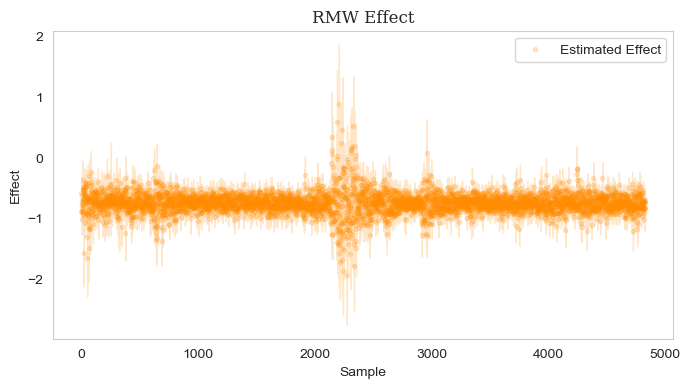

In [41]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_train)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_train)), treatment_effect_lower, treatment_effect_upper, alpha = 0.2, color = 'darkorange')
plt.scatter(range(len(X_train)), treatment_effect, label = 'Estimated Effect', marker = '.', color = 'darkorange', alpha = 0.2)
plt.title('RMW Effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

In [42]:
treatment_effect = dml_model.effect(X_test)
print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: -0.7525667742702153


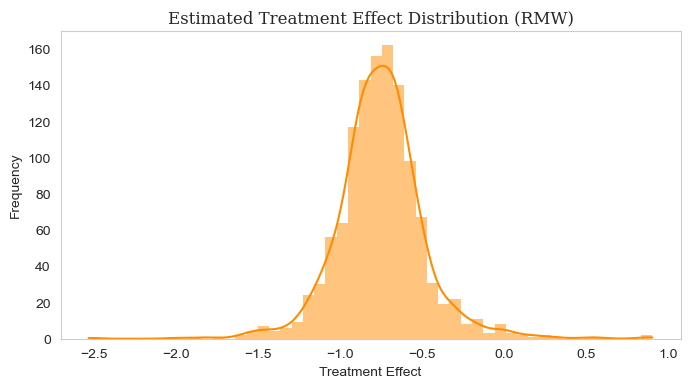

In [43]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None', color = 'darkorange')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution (RMW)', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

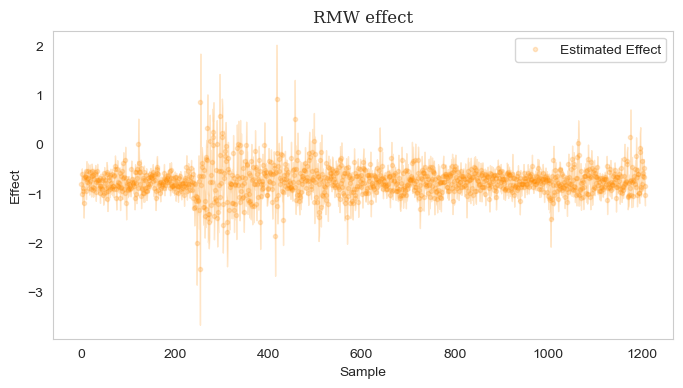

In [44]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_test)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_test)), treatment_effect_lower, treatment_effect_upper, alpha = 0.2, color = 'darkorange')
plt.scatter(range(len(X_test)), treatment_effect, label='Estimated Effect', marker = '.', color = 'darkorange', alpha = 0.2)
plt.title('RMW effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

**CMA**

In [45]:
dml_model = LinearDML(
    model_y = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    model_t = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    random_state = 42
)

X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
    X[['const', 'HML', 'RMW', 'SMB']], 
    X['CMA'], 
    y, 
    test_size = 0.2, 
    shuffle = False
)

In [46]:
dml_model.fit(Y = y_train, 
              T = T_train, 
              X = X_train)

treatment_effect = dml_model.effect(X_train)

print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: -0.5086477616759286


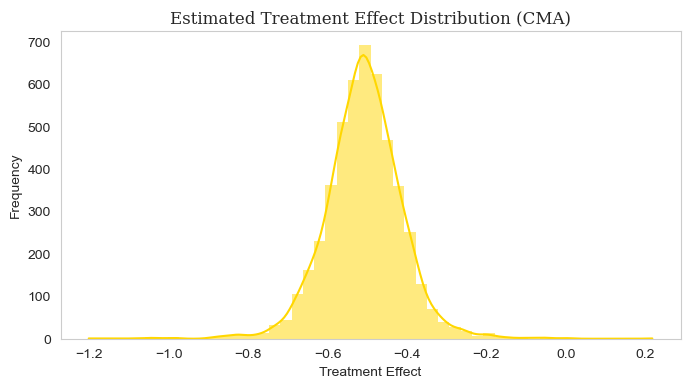

In [47]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None', color = 'gold')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution (CMA)', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

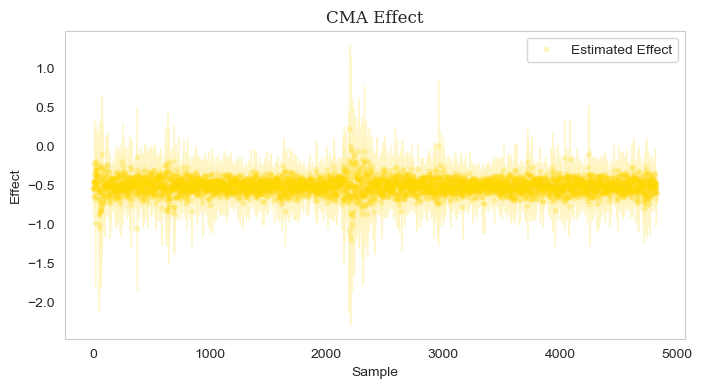

In [48]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_train)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_train)), treatment_effect_lower, treatment_effect_upper, alpha = 0.2, color = 'gold')
plt.scatter(range(len(X_train)), treatment_effect, label = 'Estimated Effect', marker = '.', color = 'gold', alpha = 0.2)
plt.title('CMA Effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

In [49]:
treatment_effect = dml_model.effect(X_test)
print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: -0.5104300974660719


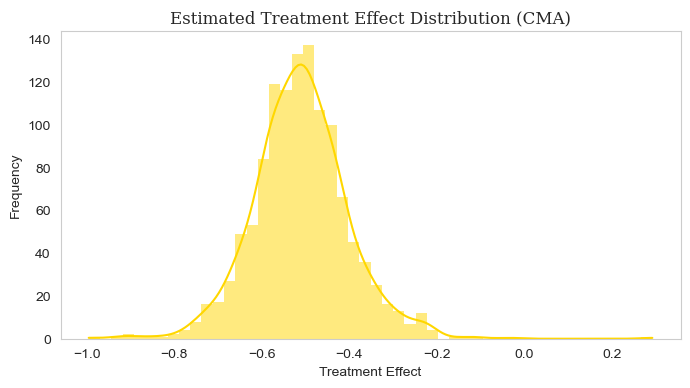

In [50]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None', color = 'gold')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution (CMA)', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

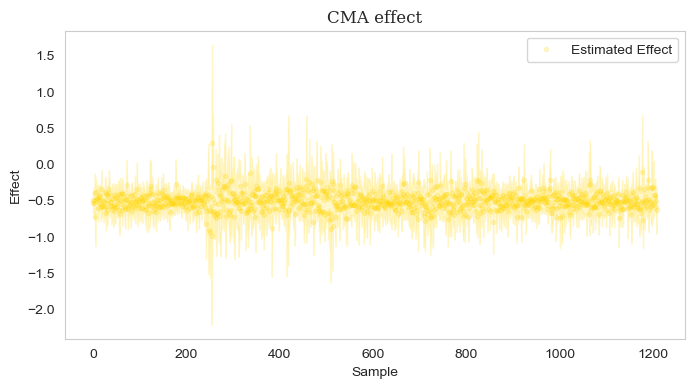

In [51]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_test)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_test)), treatment_effect_lower, treatment_effect_upper, alpha = 0.2, color = 'gold')
plt.scatter(range(len(X_test)), treatment_effect, label='Estimated Effect', marker = '.', color = 'gold', alpha = 0.2)
plt.title('CMA effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()